In [1]:
import omicverse as ov
import scanpy as sc
ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.9, Tutorials: https://omicverse.readthedocs.io/


In [2]:
sc.settings.verbosity=0

In [3]:
import os
organ_name=[i for i in os.listdir('data/mouse_atlas_drop') if 'tar.gz' not in i]
organ_name

['Liver',
 'Colon',
 'Trachea',
 'Thymus',
 'Brain_Neurons',
 'Bladder',
 'Marrow',
 'Pancreas',
 'Muscle',
 'Tongue',
 'Fat',
 'Mammary',
 'Kidney',
 'Brain_Microglia',
 'Spleen',
 'Heart',
 'Lung']

In [ ]:
#re_dicts={}
import gc
import numpy as np
import pandas as pd
import scipy.stats
from tqdm import tqdm
human_std={}
human_median={}
human_max={}
human_min={}
human_mean={}
eval_dict={}
kl_pd_dict={}
for e in tqdm(range(10100,20100,100)):
    for o in organ_name:
        adata=sc.read_h5ad(f'data/mouse_h5ad/{o}_drop_raw.h5ad')
        adata.layers['counts']=adata.X.copy()
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, n_top_genes=e, 
                                    flavor="seurat_v3",layer='counts',)
        adata=adata[:,adata.var['highly_variable']==True]


        array=adata.X.toarray()
        del adata
        gc.collect()
        human_std[o]=np.std(array,axis=0)
        human_median[o]=np.median(array,axis=0)
        human_max[o]=np.max(array,axis=0)
        human_min[o]=np.min(array,axis=0)
        human_mean[o]=np.mean(array,axis=0)
        
        
        df=pd.DataFrame(columns=['x','g'])
        k=0
        for i in human_std.keys():
            df1=pd.DataFrame()
            df1['x']=human_std[i]
            df1['g']=[j for j in [i.replace('TS_','')]*len(df1)]
            df1['x1']=[j for j in [k]*len(df1)]
            df1['x']=df1['x']+df1['x1']
            del df1['x1']
            df=pd.concat([df,df1])
            k+=0

        import joypy
        corr_feature = ['x','g']
        corr_df = df[corr_feature]
        eval_dict[e]=corr_df
        del array
        
        
    kl_pd=pd.DataFrame(index=organ_name,columns=organ_name)
    for o1 in organ_name:
        for o2 in organ_name:
            p=corr_df.loc[corr_df['g']==o1,'x'].values
            q=corr_df.loc[corr_df['g']==o2,'x'].values
            kl_pd.loc[o1,o2]=scipy.stats.ks_2samp(p, q, 
                                                   alternative='two-sided', mode='auto')[0]
    kl_pd_dict[e]=kl_pd
    for o1 in organ_name:
        kl_pd_dict[e][o1]=kl_pd_dict[e][o1].astype(float)


        


 11%|█         | 11/100 [10:21<1:24:16, 56.81s/it]

In [11]:
kl_pd_dict.keys()

dict_keys([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000])

In [14]:
import pickle
with open('result/kl_pd_dict_10000_20000.pkl','wb') as f:
    pickle.dump(kl_pd_dict,f)

In [15]:
import pickle
with open('result/kl_pd_dict_100_10000.pkl','rb') as f:
    kl_pd_dict1=pickle.load(f)
with open('result/kl_pd_dict_10000_20000.pkl','rb') as f:
    kl_pd_dict2=pickle.load(f)

In [16]:
plot_li=[]
for e in tqdm(range(100,10100,100)):
    plot_li.append(kl_pd_dict1[e].mean().mean())
for e in tqdm(range(10100,20100,100)):
    plot_li.append(kl_pd_dict2[e].mean().mean())

100%|██████████| 100/100 [00:00<00:00, 872.40it/s]


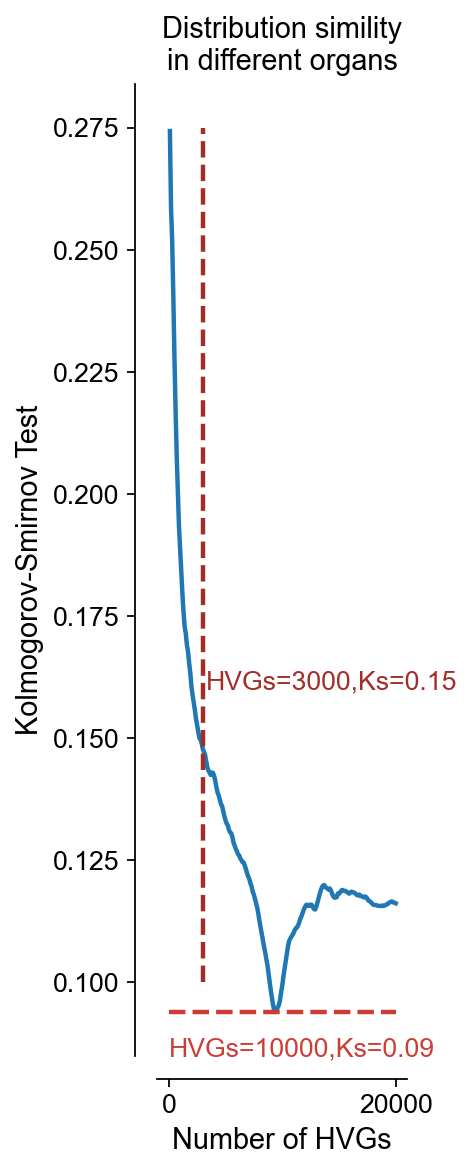

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2,8))
ax.plot(range(100,20100,100),plot_li,
       linewidth=2, )

plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Number of HVGs',fontsize=12+1)
plt.ylabel('Kolmogorov-Smirnov Test',fontsize=12+1)

ax.plot([3000,3000],
            [0.1,0.275],
            linewidth=2, 
            linestyle="--",
            color=ov.pl.red_color[3])

ax.plot([0,20000],
            [min(plot_li),min(plot_li)],
            linewidth=2, 
            linestyle="--",
            color=ov.pl.red_color[2])

plt.title('Distribution simility\nin different organs',fontsize=13)

plt.text(3300,0.16,'HVGs=3000,Ks=0.15',
         fontsize=12,color=ov.pl.red_color[3])

plt.text(0,0.085,'HVGs=10000,Ks=0.09',
         fontsize=12,color=ov.pl.red_color[2])

plt.savefig("figures/fig1/plot_hvg_test.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig1/plot_hvg_test.pdf",dpi=300,bbox_inches = 'tight')